# Purpose: Estimate, cumulate, and extrapolate and plot long wavelength radiative forcing from contrails, "other well mixed greenhouse gases", N2O, CH4, and CO2.

Clear all variables and reset the working directory and import necessary libraries

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import curve_fit
import csv
import scipy
import mpmath
from scipy.special import erf
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17Forcings')

Read the specified input file

In [2]:
df1 = pd.read_excel('heat18parameters06jan.xlsx')
df1.to_csv('heat18parameters06jan.csv',header=False,index=False)
df1 = pd.read_csv('heat18parameters06jan.csv')
print (df1) 

            b1  JulianYrEtc    b3(Years)           b4  No.  No..1  \
0    10.664400  2003.340000    31.480700     1.000000   r1      1   
1     3.465660  2003.340000   162.813000   212.309000   f2      1   
2    18.252000  2011.180000    29.304500     2.130000   r3      4   
3     0.242542  1910.930000    19.632700     0.271308   g4      5   
4     0.199856  1932.790000     5.562510     1.515180   g5      5   
5     0.770546  1959.730000     9.130070     1.000000   g6      5   
6     0.964413  1993.140000    15.208900     1.000000   g7      5   
7    64.156200   871.320000   237.898000     1.000000   f8      1   
8   176.655000  1973.910000    41.383600     9.514280   r9      1   
9     5.140880   735.908000     7.279600     1.000000  r10      1   
10    2.390980  2003.340000    40.317800   128.012000  r11      1   
11    0.360664  1980.040000     7.521900  1750.000000  r12      1   
12    0.169096  2026.340000    17.811800  2017.000000  r13      1   
13    3.465660  2003.340000   162.

In [3]:
b1 = df1.iloc[:,0:1]
b1 = b1['b1'].tolist()
b1 = list(map(float, b1))

b2 = df1.iloc[:,1:2]
b2 = b2['JulianYrEtc'].tolist()
b2 = list(map(float, b2))

b3 = df1.iloc[:,2:3]
b3 = b3['b3(Years)'].tolist()
b3 = list(map(float, b3))

b4 = df1.iloc[:,3:4]
b4 = b4['b4'].tolist()
b4 = list(map(float, b4))

# print (b3)

[31.4807, 162.813, 29.3045, 19.6327, 5.56251, 9.13007, 15.2089, 237.898, 41.3836, 7.2796, 40.3178, 7.5219, 17.8118, 162.813, 29.9806, 20.064, 42.943999999999996, 277.853, 722.065, 267.291, 0.166427, 1.0, 5.084309999999999, 1365.57, 257.658, 11.0, 5.5, 1.0]


Forcings

Contrails and Other Greenhouse Gases

In [4]:
def rad1(t):
     y = b1[12]/(1 + np.exp(-(t - b2[12])/b3[12]))
     return y

print(b1[11])

def rad2(t):
    y = b1[11]/(1 + np.exp(-(t - b2[11])/b3[11]))
    return y         

0.360664


N2O

In [5]:
def xn2o(t):
     y = (t - b2[10])/b3[10]
     return y

delta = b3[10]/b4[10]
        
def n2ofitindef(t):
     y = b1[10]*b3[10]*(np.log(1+np.exp(xn2o(t)))+delta*mpmath.polylog(2,-np.exp(xn2o(t)))-delta**2*mpmath.polylog(3,-np.exp(xn2o(t))))
     return y

t0 = 1750
tnow = 2017
# xn2o0 = xn2o(t0)
n2ofit0 = n2ofitindef(t0)
n2o0 = b3[19]

def n2ofit(t):
     y = n2o0 + n2ofitindef(t) - n2ofit0 + b1[22]/(1 + np.exp(-(t - b2[22])/b3[22]))
     return y

n2ofit = np.vectorize(n2ofit)

def rad3(t):
     y = b1[19] + b2[19]*(n2ofit(t) - b3[19])
     return y
 
# t = np.arange(t0,tnow+1)
# plt.plot(t,rad3(t))
    

CH4

In [6]:
ch40 = b3[18]
life = b4[8] #(* from heat17ch4emissions14dec.nb *)
eps = life/b3[8]
def x1(t):
     y = (t-b2[8])/b3[8]
     return y
def u(t):
     y = 1/(1 + np.exp(-x1(t)))
     return y

def ch4fit(t):
     y = ch40 + life*b1[8]*u(t)*(1-eps*(1-u(t))-eps**2*(1-u(t))*(1-2*u(t)))
     return y
def rad4(t):
     y = b1[18] + b2[18]*(ch4fit(t)-b3[18])
     return y

print (rad4(2010))


0.5130045638443355


CO2 from Land Use Changes

In [7]:
co20 = b3[17]
gtonnecperppm = 2.13;

def dlogint(t):
     y = b1[1]/(1 + np.exp(-(t - b2[1])/b3[1]))
     return y
dlogint0 = dlogint(t0)
# print (dlogint0)

def co2logintland(t):
     y = b4[1]*(dlogint(t) - dlogint0)/gtonnecperppm
     return y

def gaussint(t,b1g,b2g,b3g):
     y = b1g*b3g*np.sqrt(np.pi/2)*(-erf((b2g - t)/(b3g*np.sqrt(2))) + erf((b2g - t0)/(b3g*np.sqrt(2))))
     return y

# bg1 = np.zeros(shape=(4,1))
# bg2 = np.zeros(shape=(4,1))
# bg3 = np.zeros(shape=(4,1))

# for i in range(0,4):
#     bg1[i] = b1[i+3]
#     bg2[i] = b2[i+3]
#     bg3[i] = b3[i+3]
    
# bg = [] # results from co2 landuse fit from (g1 b1 d1) to (g4 b4 d4).
# for i in range(3,7):
#     sub_list=[]
#     for m in range(0,3):
#         x = b1[i,m].tolist()
#         sub_list.append(float(x))
#     bg.append(sub_list)
# #     new_list.append(sub_list)
# print (bg)
# print (bg[0][0])

bg = [] # results from co2 landuse fit from (g1 b1 d1) to (g4 b4 d4).
for i in range(3,7):
    sub_list=[]
    for m in range(0,3):
        x = df1.iloc[i,m].tolist()
        sub_list.append(float(x))
    bg.append(sub_list)
# print (bg)
# print (bg[0][0])

def gaussland(t):
#      y = gaussint(t,bg1[0],bg2[0],bg3[0])+gaussint(t,bg1[1],bg2[1],bg3[1])+gaussint(t,bg1[2],bg2[2],bg3[2])+gaussint(t,bg1[3],bg2[3],bg3[3])
     y = gaussint(t,bg[0][0],bg[0][1],bg[0][2])+gaussint(t,bg[1][0],bg[1][1],bg[1][2])+gaussint(t,bg[2][0],bg[2][1],bg[2][2])+gaussint(t,bg[3][0],bg[3][1],bg[3][2])
     return y

print (gaussland(2001))

def co2gauss(t):
     y = gaussland(t)/gtonnecperppm
     return y

def co2land(t):
     y = b4[3]*(co2logintland(t) + co2gauss(t))
     return y
# t = int(list(range(t0,tnow+1)))
# t = np.arange(t0,tnow+1)
# plt.plot(t,co2land(t))

def rad5(t):
     y = b1[17]+b2[17]*co2land(t)
     return y
# plt.figure()
# plt.plot(t,rad5(t))

print(rad5(2021))


57.9961083797746
0.6902493490808028


Industrial CO2

In [8]:
x0 = (t0-b2[2])/b3[2]

def x(t):
     y = (t-b2[2])/b3[2]
     return y

def co2ind(t):
     y = b4[3]*b4[4]*b1[2]*b3[2]*(np.log(1+np.exp(x(t)))-np.log(1+np.exp(x0)))/gtonnecperppm
     return y

print (b4[4])

def rad6(t):
     y = b1[17] + b2[17] * co2ind(t)
     return y


1.51518


Tropospheric ozone

In [9]:
def o3(t):
     y =  0.3046796148402036*np.exp(-0.0003741283886830488*(-2008.1969447572867+t)**2) + 42.160515888855294*(-0.0030623637478332457 + 0.021286138084796673*np.exp(0.006142015686708064*(2003.34-t))/(1+np.exp(0.006142015686708064*(2003.34 - t)))**2)
     return y

def rad1witho3(t):
     y = rad1(t)
     return y

def rad2witho3(t):
     y = o3(t)
     return y


def rad3witho3(t):
     y = rad2(t)
     return y

def rad4witho3(t):
     y = rad3(t)
     return y

# print (rad4witho3(2000))
# print (rad3(2000))

def rad5witho3(t):
     y = rad4(t)
     return y

# print (rad4(2000))
# print (rad5witho3(2000))


def rad6witho3(t):
     y = rad5(t)
     return y

def rad7witho3(t):
     y = rad6(t)
     return y

print(rad1witho3(2020))
print(rad2witho3(2020))
print(rad3witho3(2020))
print(rad4witho3(2020))
print(rad5witho3(2020))
print(rad6witho3(2020))
print(rad7witho3(2020))

dispatcher = {'rad1witho3': rad1witho3, 'rad2witho3': rad2witho3,'rad3witho3': rad3witho3,'rad4witho3': rad4witho3,'rad5witho3': rad5witho3,'rad6witho3': rad6witho3,'rad7witho3': rad7witho3}

# dispatcher = {'total':[rad1witho3(t),rad2witho3(t),rad3witho3(t),rad4witho3(t),rad5witho3(t),rad6witho3(t),rad7witho3(t)]}

# dispatcher = {'total':[rad1witho3(t)]}
# dispatcher = {'total':[rad1(t)]}

# dispatcher = {'foobar': [foo, bar], 'bazcat': [baz, cat]}

# def fire_all(func_list):
#     for f in func_list:
#         f()

# fire_all(dispatcher['foobar'])
# print (len(dispatcher))

# dispatcher['rad1witho3'](2000)
# dispatcher['rad2witho3'](2000)
# dispatcher['rad3witho3'](2000)
# dispatcher['rad4witho3'](2000)
# dispatcher['rad5witho3'](2000)
# dispatcher['rad6witho3'](2000)
# dispatcher['rad7witho3'](2000)

# print(type(rad1witho3))
# t = 2000

# def fire_all(total):
#     for f in total:
#         f(t)

# fire_all(dispatcher['total'])

0.06965771195754156
0.38386780428327616
0.3588947748139308
0.213935690096967
0.5541791915143218
0.6874718198240465
1.4598792005918877


Summarize of Plots

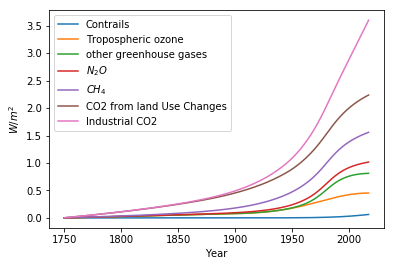

In [10]:
t = np.arange(t0,tnow+1)
plt.plot(t,rad1witho3(t),label ='Contrails')
plt.plot(t,rad1witho3(t)+rad2witho3(t), label ='Tropospheric ozone')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t), label ='other greenhouse gases')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t), label ='$N_2O$ ')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t), label ='$CH_4$')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t)+rad6witho3(t), label ='CO2 from land Use Changes')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t)+rad6witho3(t)+rad7witho3(t), label ='Industrial CO2')
plt.xlabel('Year')
plt.ylabel('$W/m^2$')
plt.legend(loc='best')
plt.savefig('sumforcings.eps',dpi=1000)
plt.savefig('sumforcings.pdf',dpi=1000)